## The linear regression problem - JAX+numpyro

In [1]:
import os

from IPython.display import set_matplotlib_formats
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

plt.style.use('bmh')
if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats('svg')

assert numpyro.__version__.startswith('0.6.0')
numpyro.set_platform("gpu")

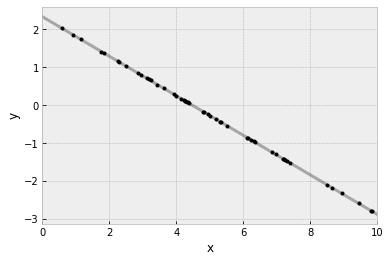

In [27]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.543

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.01*(0.1 + 0.5 * np.random.rand(N))
y = f_true * (m_true * x + b_true)
y += np.abs(f_true * y) * np.random.randn(N) * 0.01
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, f_true * (m_true * x0 + b_true), "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");


Least-squares estimates:
m = -0.522 ± 0.000
b = 2.339 ± 0.001


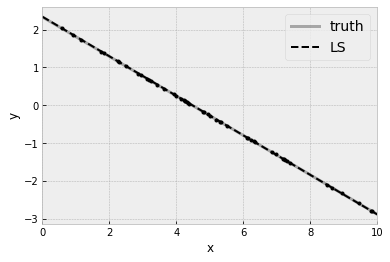

In [29]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr ** 2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr ** 2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, f_true * (m_true * x0 + b_true), "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");


In [32]:
# Choose the "true" parameters.
# b_true = 4.294
# f_true = 0.543
# m_true = -0.9594
def linear_func(m=None, x=x, b=None, f=None):
    return f*(m*x + b)

def model(x):
    b = numpyro.sample('b', dist.Uniform(2, 6))
    f = numpyro.sample('f', dist.Uniform(-1.5, 2.5))
    m = numpyro.sample('m', dist.Uniform(-3, 1))
    
    sigma = numpyro.sample('sigma', dist.Uniform(0.1, 10.0))
    # mu = f*(m*x + b)
    mu = numpyro.deterministic('mu', linear_func(m=m, x=x, b=b, f=f))
    return numpyro.sample('obs', dist.Normal(mu, sigma), obs=y)
    
#standardize = lambda x: (x - x.mean()) / x.std()
#x_scaled = standardize(x)
#y_scaled = standardize(y)#

#plt.plot(x_scaled, y_scaled, '.')
#plt.plot(x, y, 'x')

In [33]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(12)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=200)


In [34]:
mcmc.run(rng_key_, x=x)
#mcmc.run(rng_key_, x_scaled=x_scaled)
mcmc.print_summary()
samples_1 = mcmc.get_samples()
print("b_true = 4.294")
print("f_true = 0.543")
print("m_true = -0.9594")

sample: 100%|██████████| 700/700 [01:07<00:00, 10.42it/s, 47 steps of size 1.48e-02. acc. prob=0.86]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      3.95      1.04      4.00      2.01      5.25     18.65      1.00
         f      0.64      0.20      0.58      0.39      1.02     17.95      1.00
         m     -0.88      0.23     -0.89     -1.18     -0.45     18.64      1.00
     sigma      0.10      0.00      0.10      0.10      0.11     38.74      1.00

Number of divergences: 0
b_true = 4.294
f_true = 0.543
m_true = -0.9594


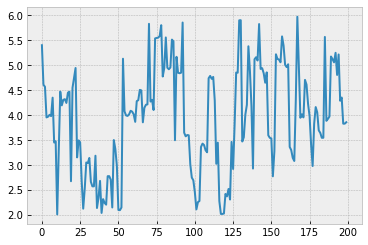

In [35]:
plt.plot(samples_1['b'])

In [40]:
def plot_regression(x, y_mean, y_hpdi, percentile_val):
    # Sort values for plotting by x axis
    idx = jnp.argsort(x)
    marriage = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(x, y_mean, '--k', linewidth=0.5, label='mean inferred (JAX)')
    ax.plot(x0, f_true * (m_true * x0 + b_true), "r", alpha=0.3, lw=3, label='true')
    #ax.plot(x, y, 'o')
    ax.errorbar(x, y, yerr=yerr, fmt='or', label='data')
    ax.fill_between(marriage, hpdi[0], hpdi[1], alpha=0.8, interpolate=True, label=f'{percentile_val} percentile')
    ax.legend()
    return ax

# Compute empirical posterior distribution over mu
posterior_mu = (jnp.expand_dims(samples_1['m'], -1) * x + \
               jnp.expand_dims(samples_1['b'], -1)) * jnp.expand_dims(samples_1['f'], -1)
mean_mu = jnp.mean(posterior_mu, axis=0)
percentile_val = 0.64
hpdi_mu = hpdi(posterior_mu, percentile_val)

<AxesSubplot:>

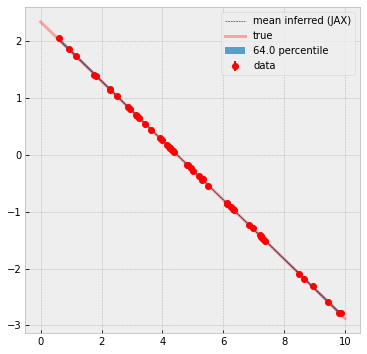

In [41]:
#plt.plot(x, y, 'x')
#plt.plot(x, mean_mu)
plot_regression(x, mean_mu, hpdi_mu, percentile_val*100)

In [42]:
numpyro.set_platform('gpu')

In [ ]:
mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)
ax = plot_regression(y, mean_mu, hpdi_mu)
ax.set(xlabel='Marriage rate', ylabel='Divorce rate', title='Regression line with 90% CI');

In [ ]:
?numpyro.plate

In [ ]:
?dist.Uniform

In [ ]:
run test1.py --device "gpu"

In [ ]:
run test1.py --device "cpu"

In [ ]:
?dist.Normal